In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from meus.printer import *
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

data = str(datetime.now().year)+'-'+str(datetime.now().month)+'-'+str(datetime.now().day)
data

'2020-4-24'

In [2]:
os.chdir('E:\\OneDrive\\Programação\\python\\covid\\data\\results')
directory = os.listdir('..')
printLis(directory)

-------------
-=< Lista >=-
-------------
0 -> .ipynb_checkpoints
1 -> artigo
2 -> caso_full.csv
3 -> cities.csv
4 -> covid19_municipios.csv
5 -> COVID19_REGIOES BR.csv
6 -> Dados_demográficos_municípios.xlsx
7 -> Dados_demográficos_municípios_new.xlsx
8 -> Datalab_COVID.pptx
9 -> figures
10 -> idade.xlsx
11 -> obito_cartorio.csv
12 -> População residente municipal x população faixa etária.csv
13 -> População residente por estado - 2015.csv
14 -> População residente x sexo.csv
15 -> results


In [3]:
date = 2
df_cov =  pd.read_csv('..\\'+directory[date])
df_cov.tail()

,city,city_ibge_code,date,estimated_population_2019,is_repeated,is_last,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,place_type,state,new_confirmed,new_deaths
26577,NaN,43.0,2020-04-22,11377239.0,False,True,970,8.52579,2020-04-22,0.0289,28,state,RS,52,1
26578,NaN,42.0,2020-04-22,7164788.0,False,True,1115,15.56222,2020-04-22,0.0350,39,state,SC,24,2
26579,NaN,28.0,2020-04-22,2298696.0,False,True,118,5.13335,2020-04-22,0.0593,7,state,SE,1,0
26580,NaN,35.0,2020-04-22,45919049.0,False,True,15914,34.65664,2020-04-22,0.0713,1134,state,SP,529,41
26581,NaN,17.0,2020-04-22,1572866.0,False,True,37,2.35239,2020-04-22,0.0541,2,state,TO,1,0


In [4]:
# df_cov = df_cov[(df_cov['last_available_date'] == '2020-04-10') & (df_cov['place_type'] == 'city')][[
#     "estimated_population_2019",
#     "last_available_confirmed",
#     "last_available_deaths",
#     "last_available_confirmed_per_100k_inhabitants",
#     "last_available_death_rate",
#     "city",
#     "last_available_date"
# ]]
# df_cov = df_cov.rename(columns={
#     "estimated_population_2019": "Population",
#     "last_available_confirmed": "Confirmed",
#     "last_available_deaths": "Deaths",
#     "last_available_confirmed_per_100k_inhabitants": "Confirmed/100k",
#     "last_available_death_rate": "Death Rate",
#     "city": "City",
#     "last_available_date": "Date"
# })
# df_cov.index.name = 'Date'
# df_cov.head()

In [5]:
df_cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26582 entries, 0 to 26581
Data columns (total 15 columns):
city                                             25477 non-null object
city_ibge_code                                   26151 non-null float64
date                                             26582 non-null object
estimated_population_2019                        26151 non-null float64
is_repeated                                      26582 non-null bool
is_last                                          26582 non-null bool
last_available_confirmed                         26582 non-null int64
last_available_confirmed_per_100k_inhabitants    25749 non-null float64
last_available_date                              26582 non-null object
last_available_death_rate                        6174 non-null float64
last_available_deaths                            26582 non-null int64
place_type                                       26582 non-null object
state                                     

In [6]:
teste = 'date'
df_cov = df_cov[['last_available_confirmed', 'last_available_deaths', 'last_available_confirmed_per_100k_inhabitants', teste]]
df_cov[teste] = pd.to_datetime(df_cov[teste])
group = df_cov.groupby(teste)
df = pd.DataFrame()
df['Confirmed'] = group.sum()['last_available_confirmed']
df['Deaths'] = group.sum()['last_available_deaths']
df['Confirmed/100k'] = group.sum()['last_available_confirmed_per_100k_inhabitants']
df.index.name = 'Date'
df.head()

,Confirmed,Deaths,Confirmed/100k
Date,,,
2020-02-25,2,0,0.01034
2020-02-26,2,0,0.01034
2020-02-27,2,0,0.01034
2020-02-28,4,0,0.02068
2020-02-29,4,0,0.02068


In [7]:
df.tail()

,Confirmed,Deaths,Confirmed/100k
Date,,,
2020-04-18,74348,4750,18378.87578
2020-04-19,78212,4981,19895.41860
2020-04-20,81859,5196,21028.12907
2020-04-21,87289,5542,22462.29763
2020-04-22,91859,5834,24121.67284


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2020-02-25 to 2020-04-22
Data columns (total 3 columns):
Confirmed         58 non-null int64
Deaths            58 non-null int64
Confirmed/100k    58 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.8 KB


In [9]:
g = 1
campo = 'Confirmed'
print_campo = 'n'
figsize=(30, 5)
first = '2020-' + str(df.tail(1).index.month[0] - 1) + '-' + str(df.tail(1).index.day[0])
last = '2020-' + str(df.tail(1).index.month[0] + 1) + '-' + str(df.tail(1).index.day[0])
start = '2020-' + str(df.head(1).index.month[0]) + '-' + str(df.head(1).index.day[0])
end = '2020-' + str(df.tail(1).index.month[0]) + '-' + str(df.tail(1).index.day[0])
try:
    os.mkdir('ts')
    print('Directory created')
except FileExistsError:
    print('Directory already exists')

Directory already exists


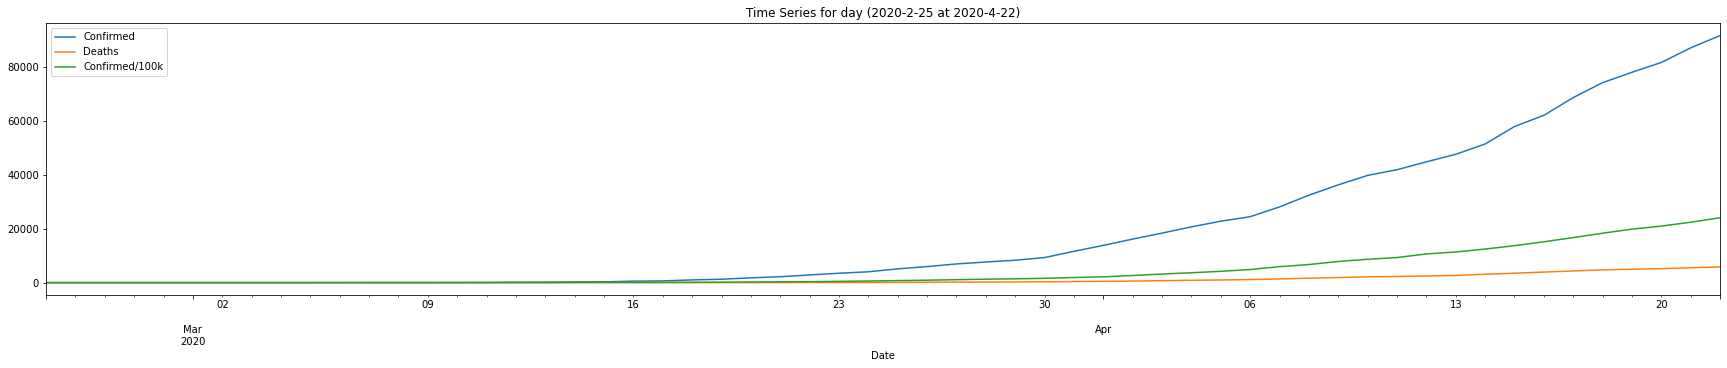

In [10]:
df.plot(figsize=figsize)
plt.title('Time Series for day ('+str(start)+' at '+str(end)+')')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

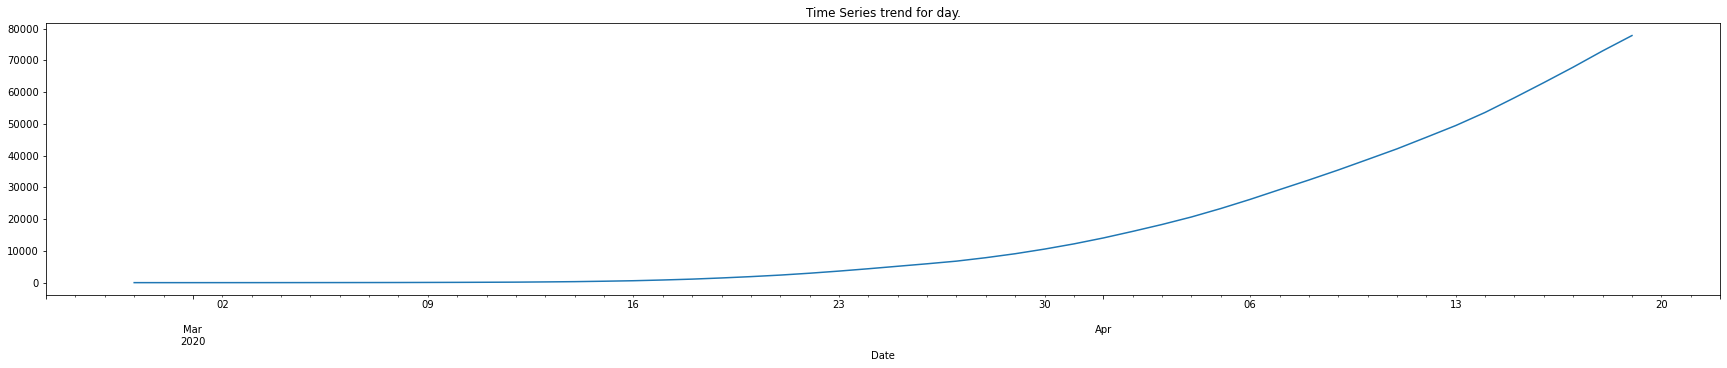

In [12]:
dec = seasonal_decompose(df[campo])
dec.trend.plot(figsize=figsize)
plt.title('Time Series trend for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

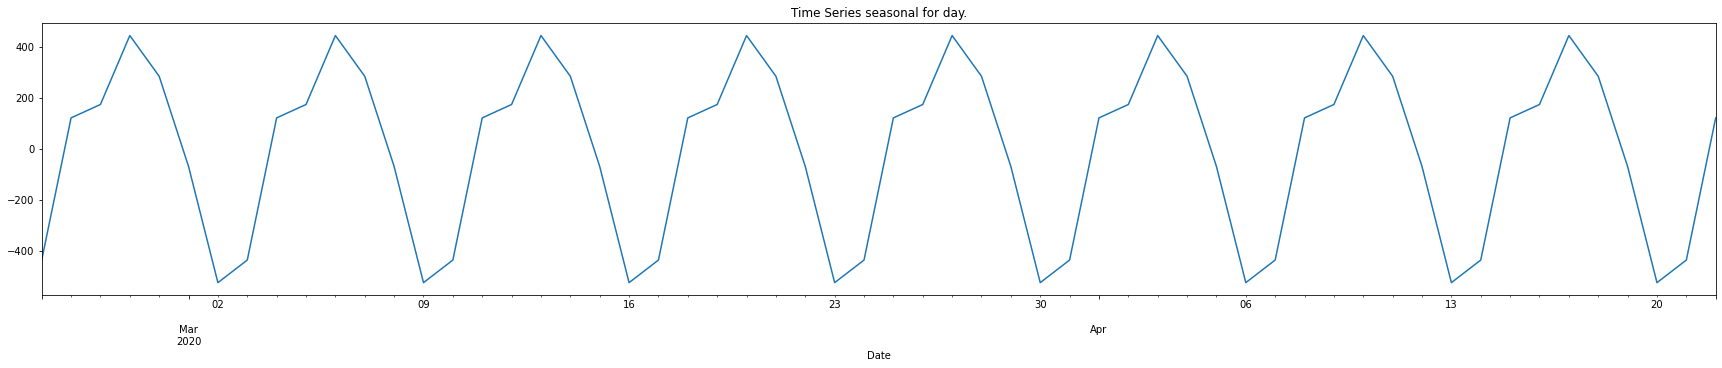

In [13]:
dec.seasonal.plot(figsize=figsize)
plt.title('Time Series seasonal for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

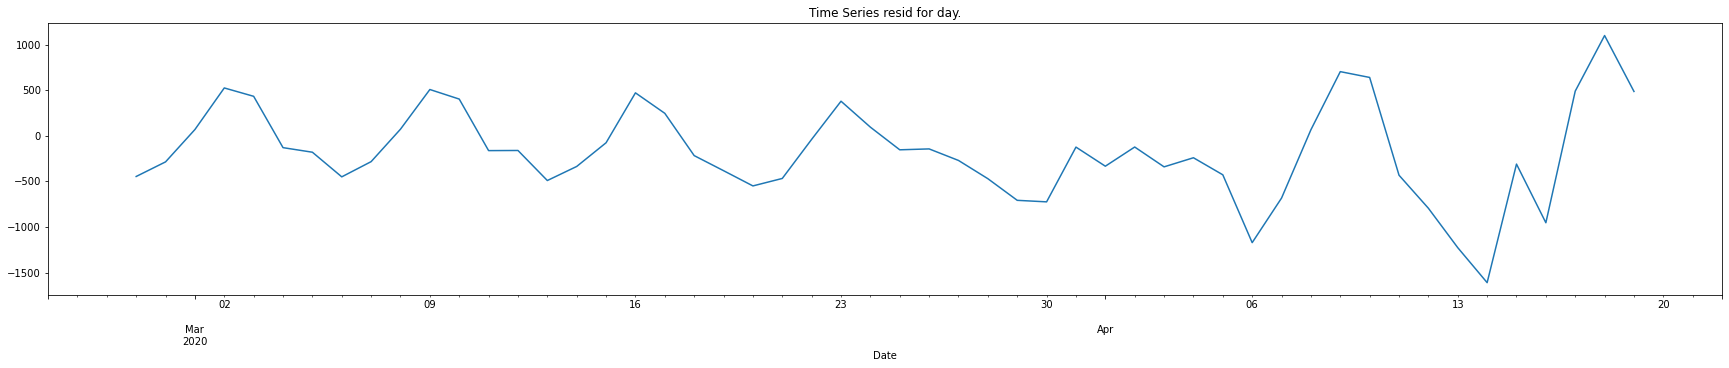

In [14]:
dec.resid.plot(figsize=figsize)
plt.title('Time Series resid for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [21]:
for p in range(3):
    for q in range(3):
        for d in range(3):
            test = (p, q, d)
            modelo = ARIMA(df[campo], order=test, freq='D')
            try:
                results = modelo.fit()
                print(f'({p}, {q}, {d})')
                print(results.summary().tables[1])
                print()
            except: 
                print('Não')

(0, 0, 0)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.925e+04   3500.224      5.499      0.000    1.24e+04    2.61e+04

(0, 0, 1)
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             1.97e+04   3589.889      5.486      0.000    1.27e+04    2.67e+04
ma.L1.Confirmed     1.0000      0.043     23.217      0.000       0.916       1.084

(0, 0, 2)
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.004e+04   3686.142      5.436      0.000    1.28e+04    2.73e+04
ma.L1.Confirmed     2.0000      0.072     27.809      0.000       1.859       2.141
ma.L2.Confirmed     1.0000      0.071     14.169      0.000

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)




(0, 1, 1)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1603.5956    291.580      5.500      0.000    1032.109    2175.082
ma.L1.D.Confirmed     0.7591      0.085      8.973      0.000       0.593       0.925

(0, 1, 2)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1607.1971    333.387      4.821      0.000     953.771    2260.623
ma.L1.D.Confirmed     0.8151      0.120      6.809      0.000       0.580       1.050
ma.L2.D.Confirmed     0.5310      0.118      4.491      0.000       0.299       0.763

(0, 2, 0)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.6071    108.926  

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2041.4422   1615.755      1.263      0.206   -1125.380    5208.265
ar.L1.D.Confirmed     0.9754      0.029     33.687      0.000       0.919       1.032
ma.L1.D.Confirmed    -0.3986      0.161     -2.480      0.013      -0.714      -0.084

(1, 1, 2)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.845e+04        nan        nan        nan         nan         nan
ar.L1.D.Confirmed     0.9999        nan        nan        nan         nan         nan
ma.L1.D.Confirmed    -0.4063      0.130     -3.124      0.002      -0.661      -0.151
ma.L2.D.Confirmed    -0.1015      0.125     -0.814      0.415      -0.346       0.143

(1, 2, 0)
                         coef  

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(1, 2, 1)
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 92.2429     31.147      2.962      0.003      31.195     153.290
ar.L1.D2.Confirmed     0.3015      0.175      1.724      0.085      -0.041       0.644
ma.L1.D2.Confirmed    -0.7900      0.104     -7.629      0.000      -0.993      -0.587

(1, 2, 2)
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 92.3709     31.153      2.965      0.003      31.313     153.429
ar.L1.D2.Confirmed     0.3645      0.391      0.932      0.351      -0.402       1.131
ma.L1.D2.Confirmed    -0.8570      0.393     -2.178      0.029      -1.628      -0.086
ma.L2.D2.Confirmed     0.0477      0.273      0.175      0.861      -0.488       0.583



C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1663: RuntimeWarning: invalid value encountered in double_scalars
  ('S.D. of innovations', ["%#5.3f" % self.sigma2 ** .5]),


(2, 0, 0)
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.925e+04        nan        nan        nan         nan         nan
ar.L1.Confirmed     1.9744   2.09e-05   9.44e+04      0.000       1.974       1.974
ar.L2.Confirmed    -0.9744   1.03e-05  -9.44e+04      0.000      -0.974      -0.974

Não
Não
(2, 1, 0)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1956.9250   1380.876      1.417      0.156    -749.542    4663.392
ar.L1.D.Confirmed     0.6547      0.126      5.212      0.000       0.408       0.901
ar.L2.D.Confirmed     0.2895      0.129      2.238      0.025       0.036       0.543



C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 1)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               3.74e+04        nan        nan        nan         nan         nan
ar.L1.D.Confirmed     1.2415      0.000   5391.414      0.000       1.241       1.242
ar.L2.D.Confirmed    -0.2415      0.000  -1048.141      0.000      -0.242      -0.241
ma.L1.D.Confirmed    -0.6349      0.096     -6.641      0.000      -0.822      -0.448



C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 2)
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.636e+04        nan        nan        nan         nan         nan
ar.L1.D.Confirmed     1.3537   6.83e-05   1.98e+04      0.000       1.354       1.354
ar.L2.D.Confirmed    -0.3537    6.9e-05  -5125.715      0.000      -0.354      -0.354
ma.L1.D.Confirmed    -0.7505      0.129     -5.807      0.000      -1.004      -0.497
ma.L2.D.Confirmed     0.0632      0.111      0.568      0.570      -0.155       0.281

(2, 2, 0)
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 85.1924     66.242      1.286      0.198     -44.640     215.025
ar.L1.D2.Confirmed    -0.3871      0.131     -2.947      0.003      -0.645      -0.130
ar.L2.D2.Confirmed    -0.1531

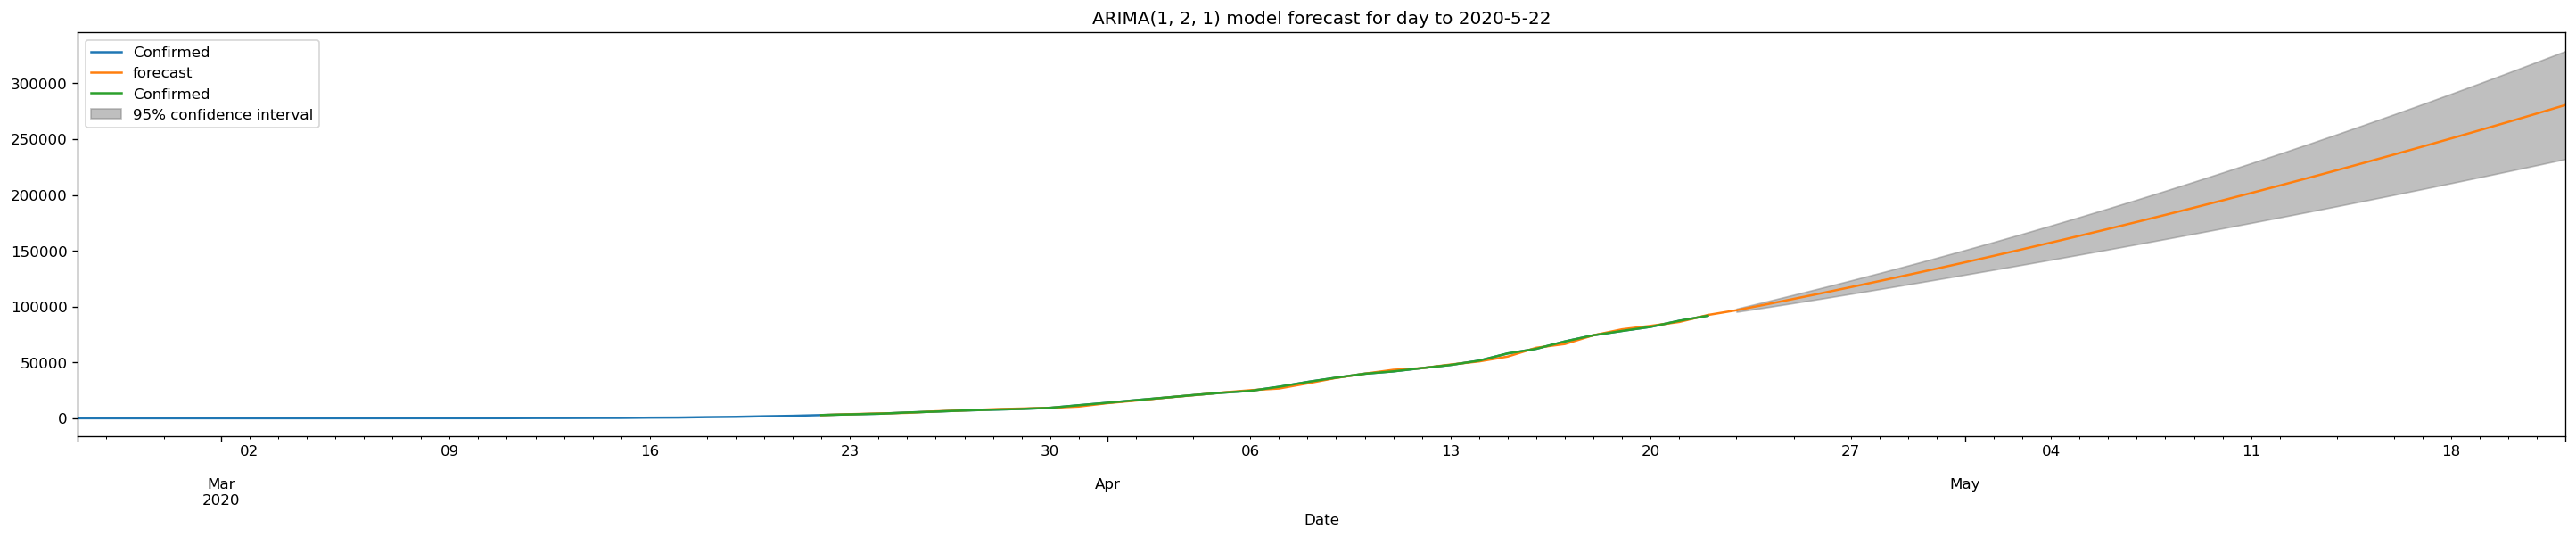

In [22]:
test = (1,2,1) #paramentros guardados em uma variável
modelo = ARIMA(df[campo], order=test, freq='D') #parametros para o modelo preditivo
results = modelo.fit() #ajuste de modelo
plt.figure(figsize=figsize) #plotando imagem
results.plot_predict(
   first, last,               #plotando a primeira e ultima data?
    ax = df['Confirmed'].plot(), #filtrando e usando apenas a coluna 'confirmed'
    plot_insample=True,
)
plt.title('ARIMA'+str(test)+' model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.Confirmed   No. Observations:                   56
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -448.435
Method:                       css-mle   S.D. of innovations            723.504
Date:                Fri, 24 Apr 2020   AIC                            904.871
Time:                        10:15:08   BIC                            912.972
Sample:                    02-27-2020   HQIC                           908.011
                         - 04-22-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 92.2429     31.147      2.962      0.003      31.195     153.290
ar.L1.D2.Confirmed     0.3015      0.175      1.724      0.085      -0.041       0.644
ma.L1.D2.Confirmed    -0.7900      0.104     -7.629      0.000      -0.993      -0.587
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.3168           +0.0000j            3.3168            0.0000
MA.1            1.2658           +0.0000j            1.2658            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
pred = results.forecast(steps=30)
pred

(array([ 96727.59215602, 101750.64117215, 106884.69047762, 112116.63798293,
        117442.5334282 , 122861.18581612, 128372.23606282, 133975.57590508,
        139671.1727017 , 145459.01661139, 151339.10466705, 157311.43597407,
        163376.01026275, 169532.82745176, 175781.88751659, 182123.19044985,
        188556.7362493 , 195082.52491428, 201700.55644459, 208410.83084015,
        215213.34810096, 222108.108227  , 229095.11121828, 236174.3570748 ,
        243345.84579655, 250609.57738354, 257965.55183576, 265413.76915322,
        272954.22933592, 280586.93238385]),
 array([  723.50415605,  1311.25571477,  1887.10141401,  2466.68468921,
         3059.65149181,  3671.29526861,  4304.31678222,  4959.97315777,
         5638.73156496,  6340.62732898,  7065.45987595,  7812.9014331 ,
         8582.55846018,  9374.0069767 , 10186.81312614, 11020.5451877 ,
        11874.78052417, 12749.10947797, 13643.13740383, 14556.48555627,
        15488.79127334, 16439.70773267, 17408.90345389, 18396.06

In [25]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
y = df[campo]
aic_list = list()
param_list = list()
param_s_list = list()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            results = sm.tsa.statespace.SARIMAX(
                            y,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False
            ).fit()
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
            param_list.append(param)
            param_s_list.append(param_seasonal)
            aic_list.append(results.aic)
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1350.4310295070434
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1075.1796365484083
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1041.6134646764026
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1442.865785192794
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:963.3473475734207
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:911.3314301765512
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:714.8408415938196
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:687.5648169093583
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1289.3682633210437
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1011.1192166429186
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:989.414432281752
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1050.738379193603
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1007.2079094224536
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:678.5867619415105
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:635.369567747518
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1036.764860635241
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:796.4684405898053
ARIMA(0, 1, 0)x(0, 1

In [28]:
best = aic_list.index(min(aic_list))
mod = sm.tsa.statespace.SARIMAX(
                                y,
                                order=param_list[best],
                                seasonal_order=param_s_list[best],
                                enforce_stationarity=False,
                                enforce_invertibility=False
)
results = mod.fit()
results.summary()
# print(results.summary().tables[1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Confirmed   No. Observations:                   58
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -265.092
Date:                             Fri, 24 Apr 2020   AIC                            538.185
Time:                                     10:15:57   BIC                            544.048
Sample:                                 02-25-2020   HQIC                           540.128
                                      - 04-22-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0462      0.017     61.645      0.000       1.013       1.079
ma.L1         -0.7394      0.199     -3.721      0.000      -1.129      -0.350
ar.S.L12      -1.6235      0.376     -4.317      0.000      -2.361      -0.886
sigma2      9.129e+05   2.38e+05      3.839      0.000    4.47e+05    1.38e+06
===================================================================================
Ljung-Box (Q):                       25.39   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.75   Prob(JB):                         0.94
Heteroskedasticity (H):               4.57   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

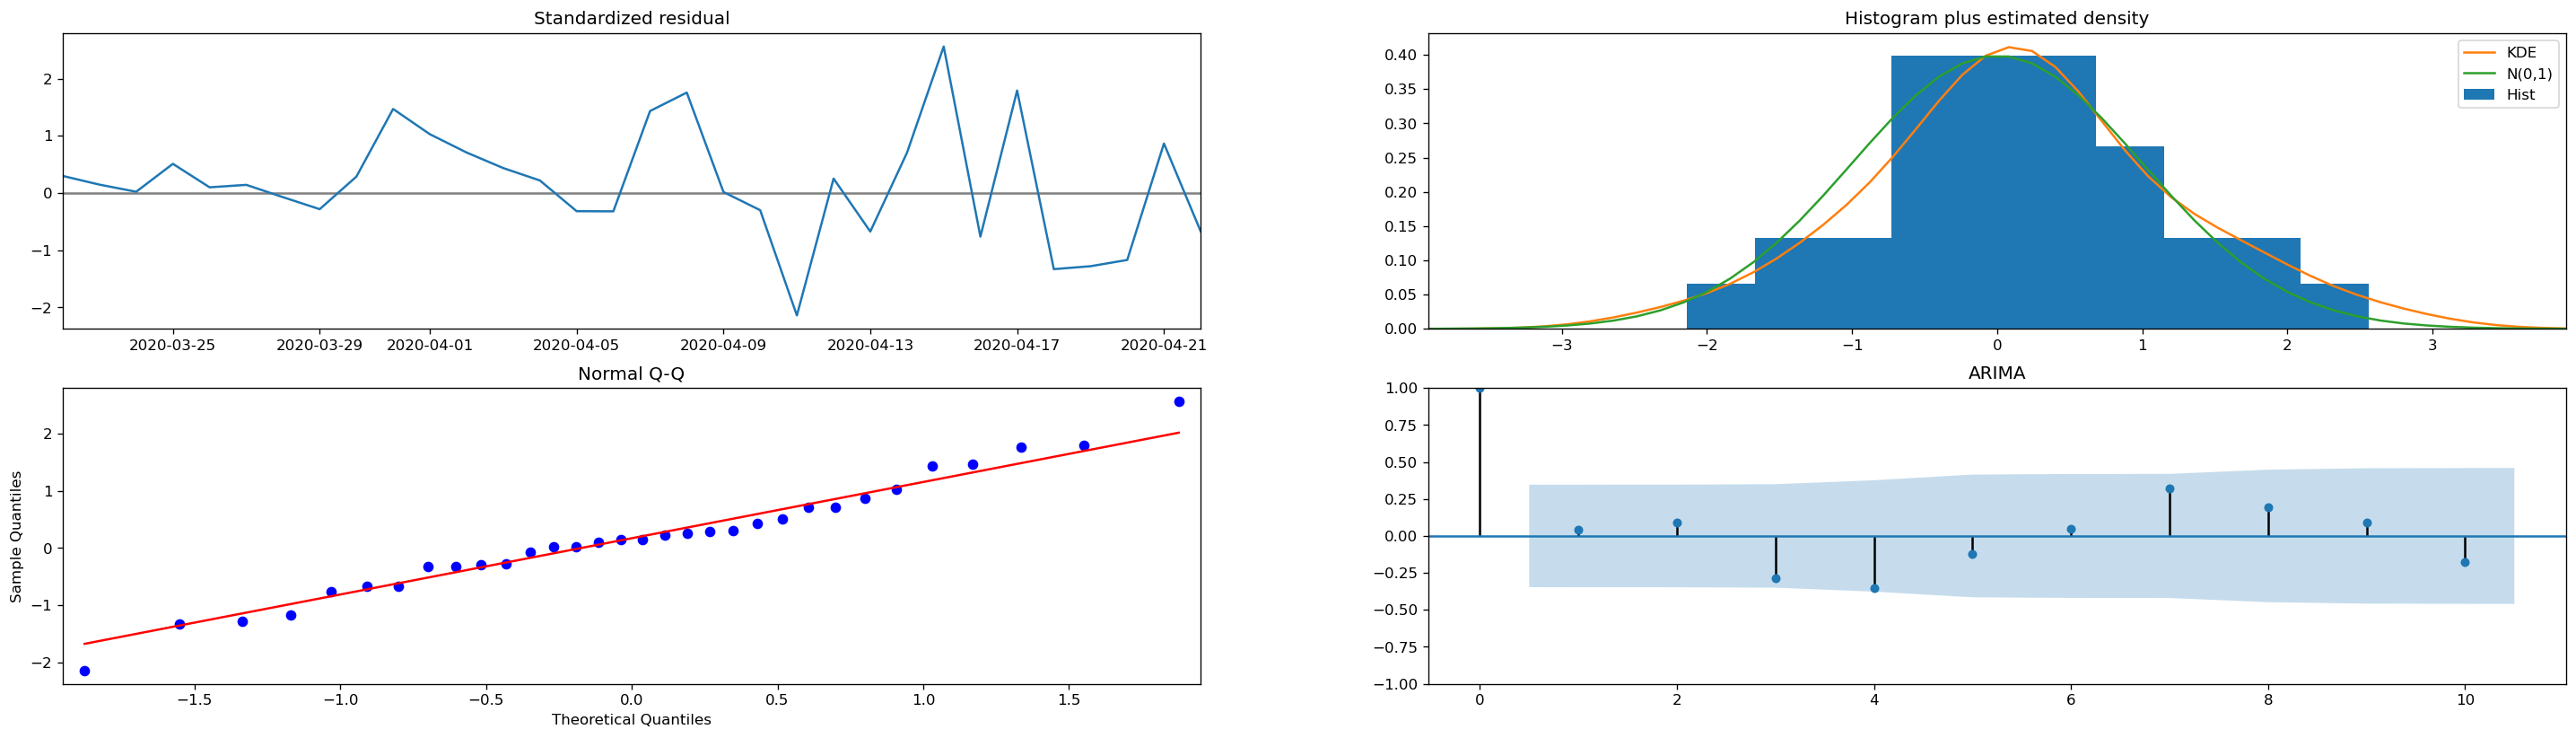

In [30]:
results.plot_diagnostics(figsize=(30, 8))
plt.title('SARIMAX')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

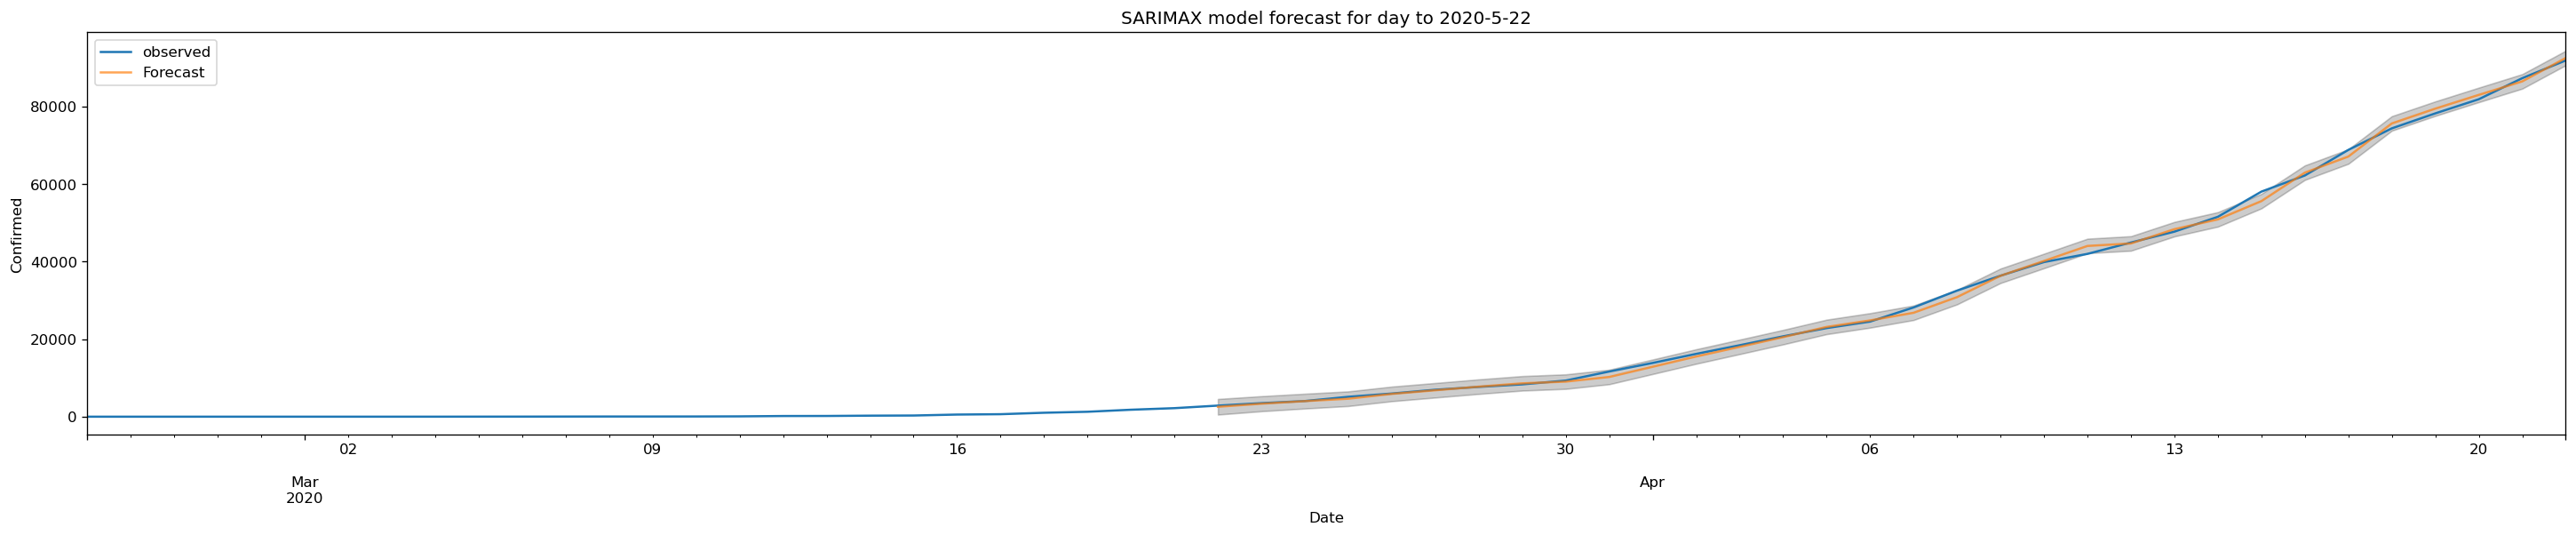

In [35]:
pred = results.get_prediction(start=pd.to_datetime(first), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=figsize)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel(campo)
plt.legend()
plt.title('SARIMAX model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [ ]:
test = (1,2,1)
modelo = ARIMA(df[campo], order=test, freq='D')
results = modelo.fit()
plt.figure(figsize=figsize)
results.plot_predict(
   first, last,
    ax = df['Confirmed'].plot(),
    plot_insample=True,
)
plt.title('ARIMA'+str(test)+' model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [32]:
y_forecasted = pred.predicted_mean
y_truth = y[first:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error is {round(mse, 2)}')
print(f'The Root Mean Squared Error is {round(np.sqrt(mse), 2)}')

The Mean Squared Error is 910537.25
The Root Mean Squared Error is 954.22


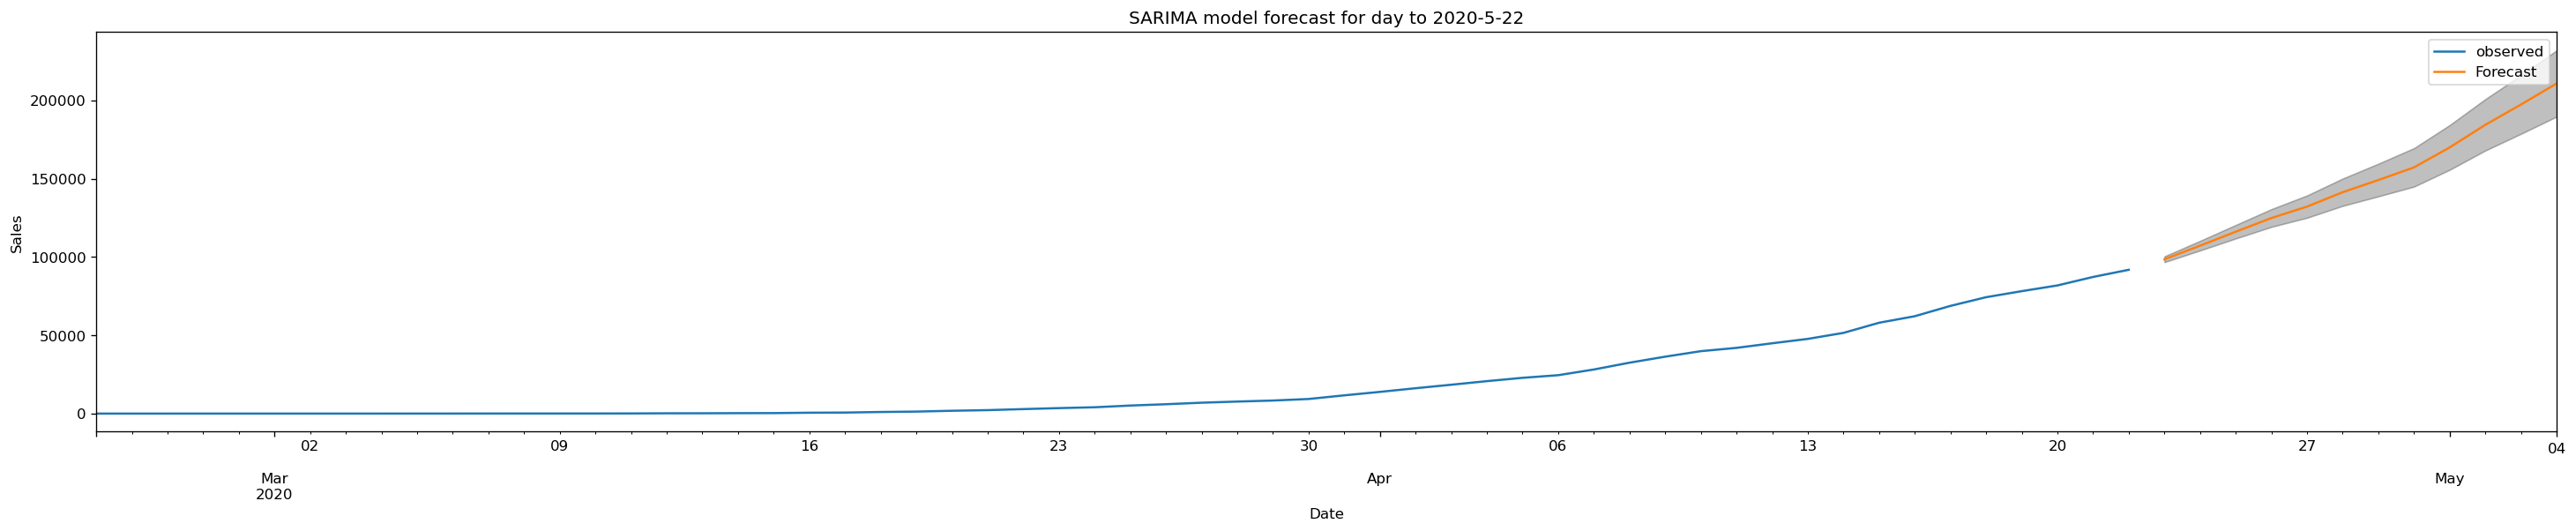

In [33]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=figsize)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.title('SARIMA model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [34]:
y_forecasted = pred.predicted_mean
y_forecasted.head()

2020-03-22    2556.323525
2020-03-23    3350.027240
2020-03-24    4014.867787
2020-03-25    4637.854621
2020-03-26    5878.534668
Freq: D, dtype: float64